# Notebook 2: Exploratory Data Analysis and Feature Engineering

**Notebook Purpose**
This notebook explores the training data and prepares features for modeling:
1. Exploratory data analysis on training data only (distributions, correlations, patterns)
2. Create derived features (ocean color indices, seasonal features)
3. Feature selection based on correlation analysis and domain knowledge
4. Feature scaling (fit on training data, apply to validation/test)
5. Save preprocessed features for model training

**Key Outputs**
- `training set.csv`: Training set with engineered features and scaled values
- `validation set.csv`: Validation set with same transformations applied
- `testing set.csv`: Test set with same transformations applied

**Data Leakage Prevention**
All EDA, feature selection, and feature engineering performed on training data only. Same transformations (with training-derived parameters) applied to validation and test sets. Test and validation sets are not examined during exploration.

## Library Imports

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import skew

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Ingestion

In [ ]:
training_set_file_path = '/content/drive/MyDrive/Colab Notebooks/MADS/SIADS 699/Data/Data Splits/Unprocessed/Training Set.csv'
validation_set_file_path = '/content/drive/MyDrive/Colab Notebooks/MADS/SIADS 699/Data/Data Splits/Unprocessed/Validation Set.csv'
testing_set_file_path = '/content/drive/MyDrive/Colab Notebooks/MADS/SIADS 699/Data/Data Splits/Unprocessed/Testing Set.csv'

training_df = pd.read_csv(training_set_file_path)
validation_df = pd.read_csv(validation_set_file_path)
testing_df = pd.read_csv(testing_set_file_path)

training_df.head()
# validation_df.head()
# testing_df.head

Cast_id  Latitude  Longitude  Year  Month  Day  Bottom_depth  Depth  \
0  16494571   54.6230    13.0280  2002      7    4          12.0    1.5   
1  13547703   54.5960    18.7737  2002      7    4          49.0    0.0   
2  13547702   54.5777    18.7477  2002      7    4          53.0    0.0   
3  13547701   54.5700    18.6800  2002      7    4          31.0    0.0   
4  13547700   54.5782    18.6610  2002      7    4          33.0    0.0   

   Oxygen        Date  ...   Rrs_412   Rrs_443   Rrs_469   Rrs_488   Rrs_531  \
0   278.0  2002-07-04  ...  0.002476  0.001970  0.002248  0.002200  0.002864   
1   322.0  2002-07-04  ...  0.002618  0.002244  0.002216  0.002240  0.002920   
2   320.0  2002-07-04  ...  0.002444  0.001922  0.002112  0.001930  0.002808   
3   328.0  2002-07-04  ...  0.002370  0.001860  0.002052  0.001876  0.002746   
4   328.0  2002-07-04  ...  0.002370  0.001860  0.002052  0.001876  0.002746   

    Rrs_547   Rrs_555   Rrs_645   Rrs_667   Rrs_678  
0  0.002758  0.002608  0.000644  0.000538  0.000604  
1  0.002790  0.002660  0.000500  0.000304  0.000334  
2  0.002870  0.002730  0.000560  0.000338  0.000350  
3  0.002794  0.002656  0.000522  0.000308  0.000322  
4  0.002794  0.002656  0.000522  0.000308  0.000322  

[5 rows x 23 columns]

## Exploratory Data Analysis

In [ ]:
# Define columns to exclude from analysis
exclude_cols = ['Cast_id', 'Year', 'Month', 'Day', 'Date']

# Separate into numeric and categorical (excluding unwanted columns)
numeric_cols = [col for col in training_df.select_dtypes(include=[np.number]).columns if col not in exclude_cols]
categorical_cols = [col for col in training_df.select_dtypes(exclude=[np.number]).columns if col not in exclude_cols]

# Display the lists of numeric and categorical variables for reference
print("Numeric Variables: "+str(numeric_cols))
print("Categorical Variables: "+str(categorical_cols))

# Generate descriptive statistics for numeric variables
training_df[numeric_cols].describe().T

Numeric Variables: ['Latitude', 'Longitude', 'Bottom_depth', 'Depth', 'Oxygen', 'chlor_a', 'poc', 'sst', 'Rrs_412', 'Rrs_443', 'Rrs_469', 'Rrs_488', 'Rrs_531', 'Rrs_547', 'Rrs_555', 'Rrs_645', 'Rrs_667', 'Rrs_678']
Categorical Variables: []


count         mean          std         min         25%  \
Latitude      34408.0    35.284801    30.267146  -77.150000   29.009950   
Longitude     34408.0    10.873470    83.240173 -179.988000  -54.286675   
Bottom_depth  34408.0  1300.547101  1878.521260    0.000000   48.000000   
Depth         34408.0    12.196612    87.626366   -0.700000    0.000000   
Oxygen        34408.0   281.793455    91.638775   -0.392000  228.157750   
chlor_a       34408.0     4.795657     9.052070    0.009997    0.322137   
poc           34408.0   466.846248  1033.464136   13.200000   85.500000   
sst           34408.0    15.582451     7.583953   -1.770000    9.993125   
Rrs_412       34408.0     0.003913     0.004162   -0.002371    0.001050   
Rrs_443       34408.0     0.003533     0.003178   -0.000726    0.001192   
Rrs_469       34408.0     0.003669     0.002757   -0.000228    0.001574   
Rrs_488       34408.0     0.003437     0.002391    0.000286    0.001661   
Rrs_531       34408.0     0.002841     0.002154    0.000690    0.001927   
Rrs_547       34408.0     0.002651     0.002288    0.000802    0.001674   
Rrs_555       34408.0     0.002456     0.002223    0.000534    0.001482   
Rrs_645       34408.0     0.000704     0.001357   -0.000892    0.000202   
Rrs_667       34408.0     0.000586     0.001139   -0.001222    0.000182   
Rrs_678       34408.0     0.000622     0.001090   -0.001398    0.000202   

                     50%          75%           max  
Latitude       48.575150    56.370800     82.125700  
Longitude      14.045700    25.169300    179.922700  
Bottom_depth  113.000000  2381.250000   9436.000000  
Depth           1.000000     3.570000   4797.940000  
Oxygen        271.000000   323.000000   9261.200000  
chlor_a         1.493799     4.780452     97.553322  
poc           210.600006   416.900002  12953.400391  
sst            16.430000    20.764999     33.239998  
Rrs_412         0.002444     0.005273      0.032276  
Rrs_443         0.002438     0.004929      0.031364  
Rrs_469         0.002795     0.005064      0.031466  
Rrs_488         0.002791     0.004700      0.030229  
Rrs_531         0.002353     0.002906      0.033492  
Rrs_547         0.002020     0.002690      0.033770  
Rrs_555         0.001828     0.002504      0.031850  
Rrs_645         0.000370     0.000678      0.020900  
Rrs_667         0.000312     0.000569      0.018684  
Rrs_678         0.000357     0.000649      0.018144

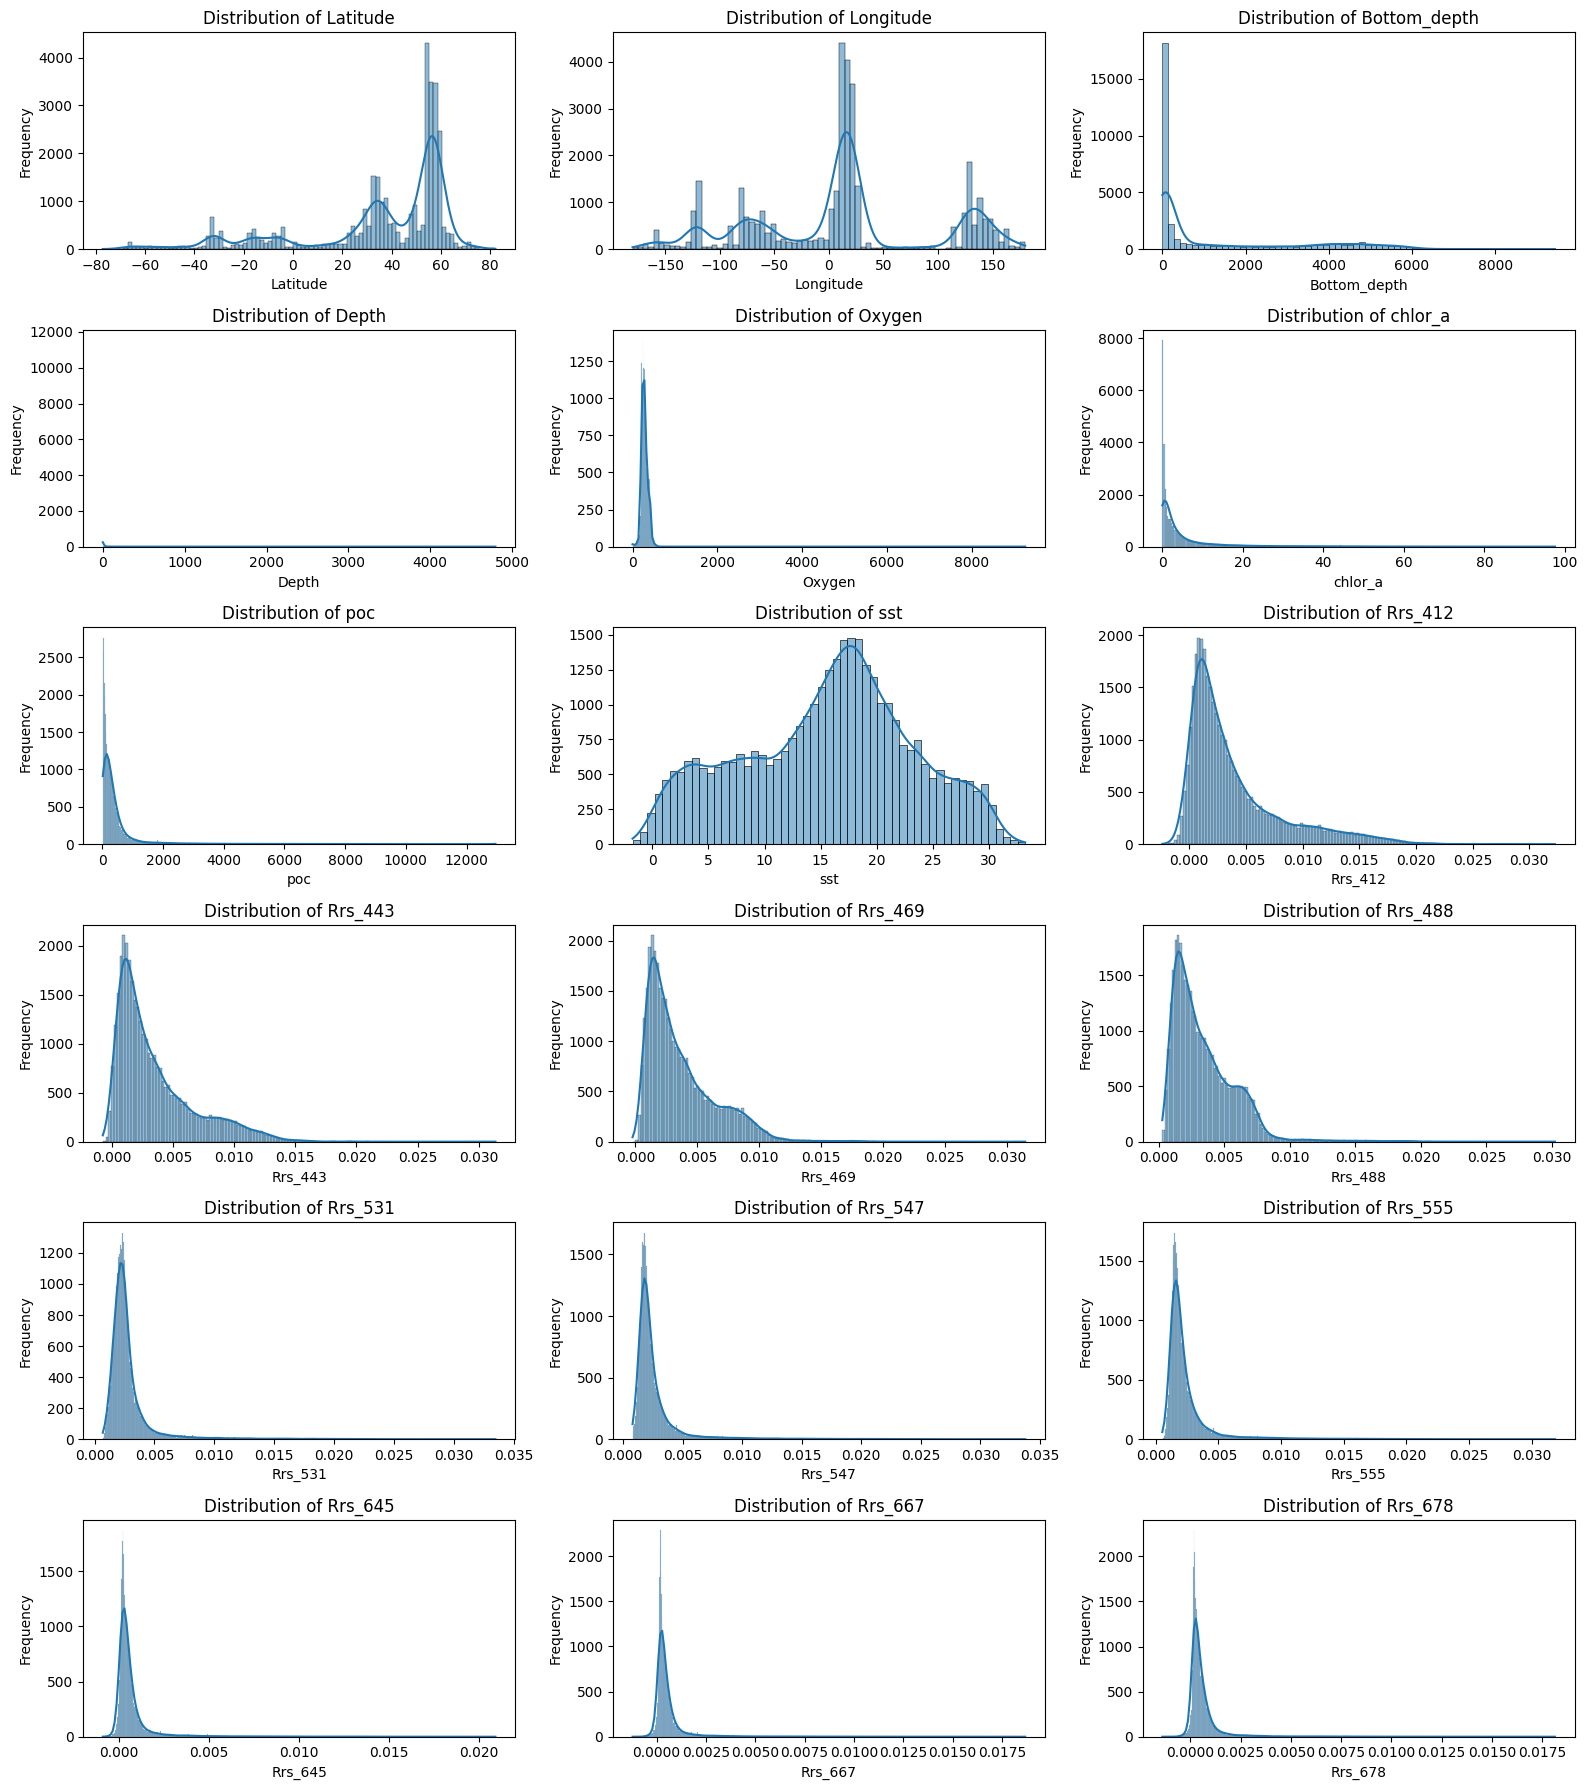

In [ ]:
def plot_numeric_histograms(df, numeric_cols, figsize=(16, 3*math.ceil(len(numeric_cols)/3))):
   """
   Create histograms for numeric columns arranged in subplots.
   Uses clean display names for titles and labels.

   Parameters:
   -----------
   df : pandas.DataFrame
       The dataframe containing the numeric columns to plot
   numeric_cols : list
       List of numeric column names to create histograms for
   figsize : tuple, optional
       Figure size as (width, height) in inches, default dynamically calculated based on column count
   """
   # Calculate layout dimensions
   n_plots = len(numeric_cols)
   n_cols = 3
   n_rows = math.ceil(n_plots / n_cols)

   # Create the figure and subplots
   fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
   axes = axes.flatten() if n_rows * n_cols > 1 else [axes]  # Flatten if multiple plots

   # Create a histogram for each numeric column
   for i, col in enumerate(numeric_cols):
       if i < len(axes):  # Ensure we don't exceed the number of subplots
           # Plot histogram with KDE (Kernel Density Estimation) curve
           sns.histplot(df[col], kde=True, ax=axes[i])
           axes[i].set_title(f'Distribution of {col}')
           axes[i].set_xlabel(col)
           axes[i].set_ylabel('Frequency')

   # Hide any unused subplots if odd number of columns
   for j in range(i+1, len(axes)):
       axes[j].set_visible(False)

   # Adjust spacing between subplots for better readability
   plt.subplots_adjust(wspace=0.3, hspace=0.4)
   plt.tight_layout()
   plt.show()

# Generate histograms for all numeric variables to visualize their distributions
plot_numeric_histograms(training_df, numeric_cols)


Feature Skewness (sorted by absolute value):

Oxygen          29.955018
Depth           23.493389
Rrs_667          6.637293
poc              6.589732
Rrs_678          6.550764
Rrs_645          6.213811
Rrs_531          4.920356
Rrs_547          4.845617
Rrs_555          4.751076
chlor_a          3.830745
Rrs_488          1.950731
Rrs_412          1.603385
Latitude         1.444395
Rrs_469          1.392060
Rrs_443          1.353529
Bottom_depth     1.232829
sst              0.174938
Longitude        0.064982
dtype: float64

Highly Skewed Features (|skewness| > 1):

Oxygen          29.955018
Depth           23.493389
Rrs_667          6.637293
poc              6.589732
Rrs_678          6.550764
Rrs_645          6.213811
Rrs_531          4.920356
Rrs_547          4.845617
Rrs_555          4.751076
chlor_a          3.830745
Rrs_488          1.950731
Rrs_412          1.603385
Rrs_469          1.392060
Rrs_443          1.353529
Bottom_depth     1.232829
Latitude        -1.444395
dtype: float

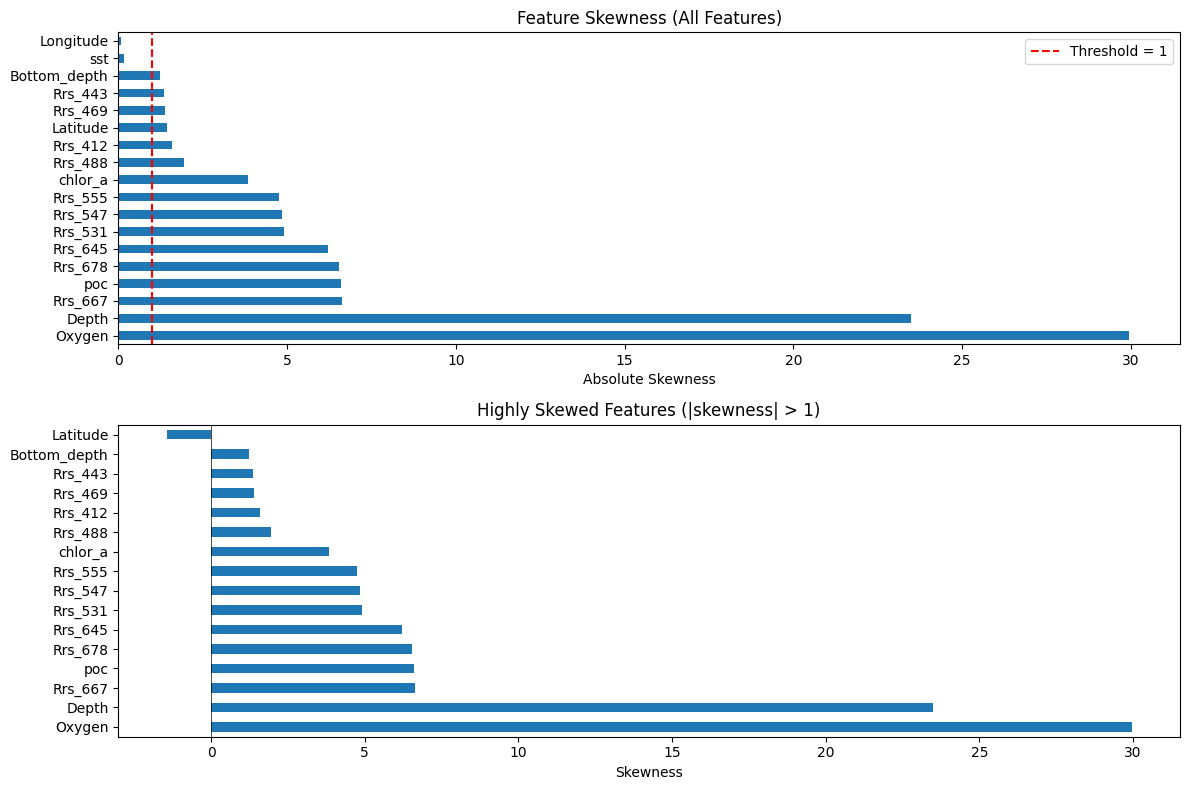

In [ ]:
# Check skewness of all numeric features in training data
skewness = training_df[numeric_cols].apply(lambda x: skew(x.dropna()))

# Sort by absolute skewness
skewness_sorted = skewness.abs().sort_values(ascending=False)

print("Feature Skewness (sorted by absolute value):\n")
print(skewness_sorted)

# Identify highly skewed features (common threshold: |skewness| > 1)
highly_skewed = skewness[skewness.abs() > 1].sort_values(ascending=False)

print("\n" + "="*50)
print("Highly Skewed Features (|skewness| > 1):\n")
print(highly_skewed)

# Visualize
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot all skewness
skewness_sorted.plot(kind='barh', ax=axes[0])
axes[0].set_xlabel('Absolute Skewness')
axes[0].set_title('Feature Skewness (All Features)')
axes[0].axvline(x=1, color='red', linestyle='--', label='Threshold = 1')
axes[0].legend()

# Plot only highly skewed
if len(highly_skewed) > 0:
    highly_skewed.plot(kind='barh', ax=axes[1])
    axes[1].set_xlabel('Skewness')
    axes[1].set_title('Highly Skewed Features (|skewness| > 1)')
    axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

In [ ]:
# Outlier Handling

# Check Oxygen outliers
print("\nOxygen quality check:")
print(f"  Min: {training_df['Oxygen'].min():.2f} μmol/kg")
print(f"  Max: {training_df['Oxygen'].max():.2f} μmol/kg")
print(f"  Values > 400: {(training_df['Oxygen'] > 400).sum()}")
print(f"  Values < 0: {(training_df['Oxygen'] < 0).sum()}")

# Define valid range (based on oceanographic knowledge)
valid_oxygen_range = (0, 400)  # μmol/kg
outlier_mask = (training_df['Oxygen'] >= valid_oxygen_range[0]) & \
               (training_df['Oxygen'] <= valid_oxygen_range[1])

n_outliers = (~outlier_mask).sum()
print(f"\nRemoving {n_outliers} outliers ({n_outliers/len(training_df)*100:.2f}%)")

# Apply to all splits
training_df = training_df[outlier_mask].copy()

# Apply same filter to validation and test
validation_df = validation_df[
    (validation_df['Oxygen'] >= valid_oxygen_range[0]) &
    (validation_df['Oxygen'] <= valid_oxygen_range[1])
].copy()

testing_df = testing_df[
    (testing_df['Oxygen'] >= valid_oxygen_range[0]) &
    (testing_df['Oxygen'] <= valid_oxygen_range[1])
].copy()

print(f"\nTraining: {len(training_df):,} samples")
print(f"Validation: {len(validation_df):,} samples")
print(f"Testing: {len(testing_df):,} samples")



Oxygen quality check:
  Min: -0.39 μmol/kg
  Max: 9261.20 μmol/kg
  Values > 400: 2679
  Values < 0: 1

Removing 2680 outliers (7.79%)

Training: 31,728 samples
Validation: 6,777 samples
Testing: 6,932 samples


In [ ]:
# Oxygen value analysis

thresholds = {
    'Severe Hypoxia (<22)': (training_df['Oxygen'] < 22).sum(),
    'Hypoxic (22-60)': ((training_df['Oxygen'] >= 22) & (training_df['Oxygen'] < 60)).sum(),
    'Low Oxygen (60-192)': ((training_df['Oxygen'] >= 60) & (training_df['Oxygen'] < 192)).sum(),
    'Normal (192-320)': ((training_df['Oxygen'] >= 192) & (training_df['Oxygen'] < 320)).sum(),
    'High Oxygen (>320)': (training_df['Oxygen'] >= 320).sum()
}

for category, count in thresholds.items():
    pct = count / len(training_df) * 100
    print(f"  {category}: {count:,} ({pct:.1f}%)")

  Severe Hypoxia (<22): 86 (0.3%)
  Hypoxic (22-60): 69 (0.2%)
  Low Oxygen (60-192): 1,437 (4.5%)
  Normal (192-320): 23,812 (75.1%)
  High Oxygen (>320): 6,324 (19.9%)


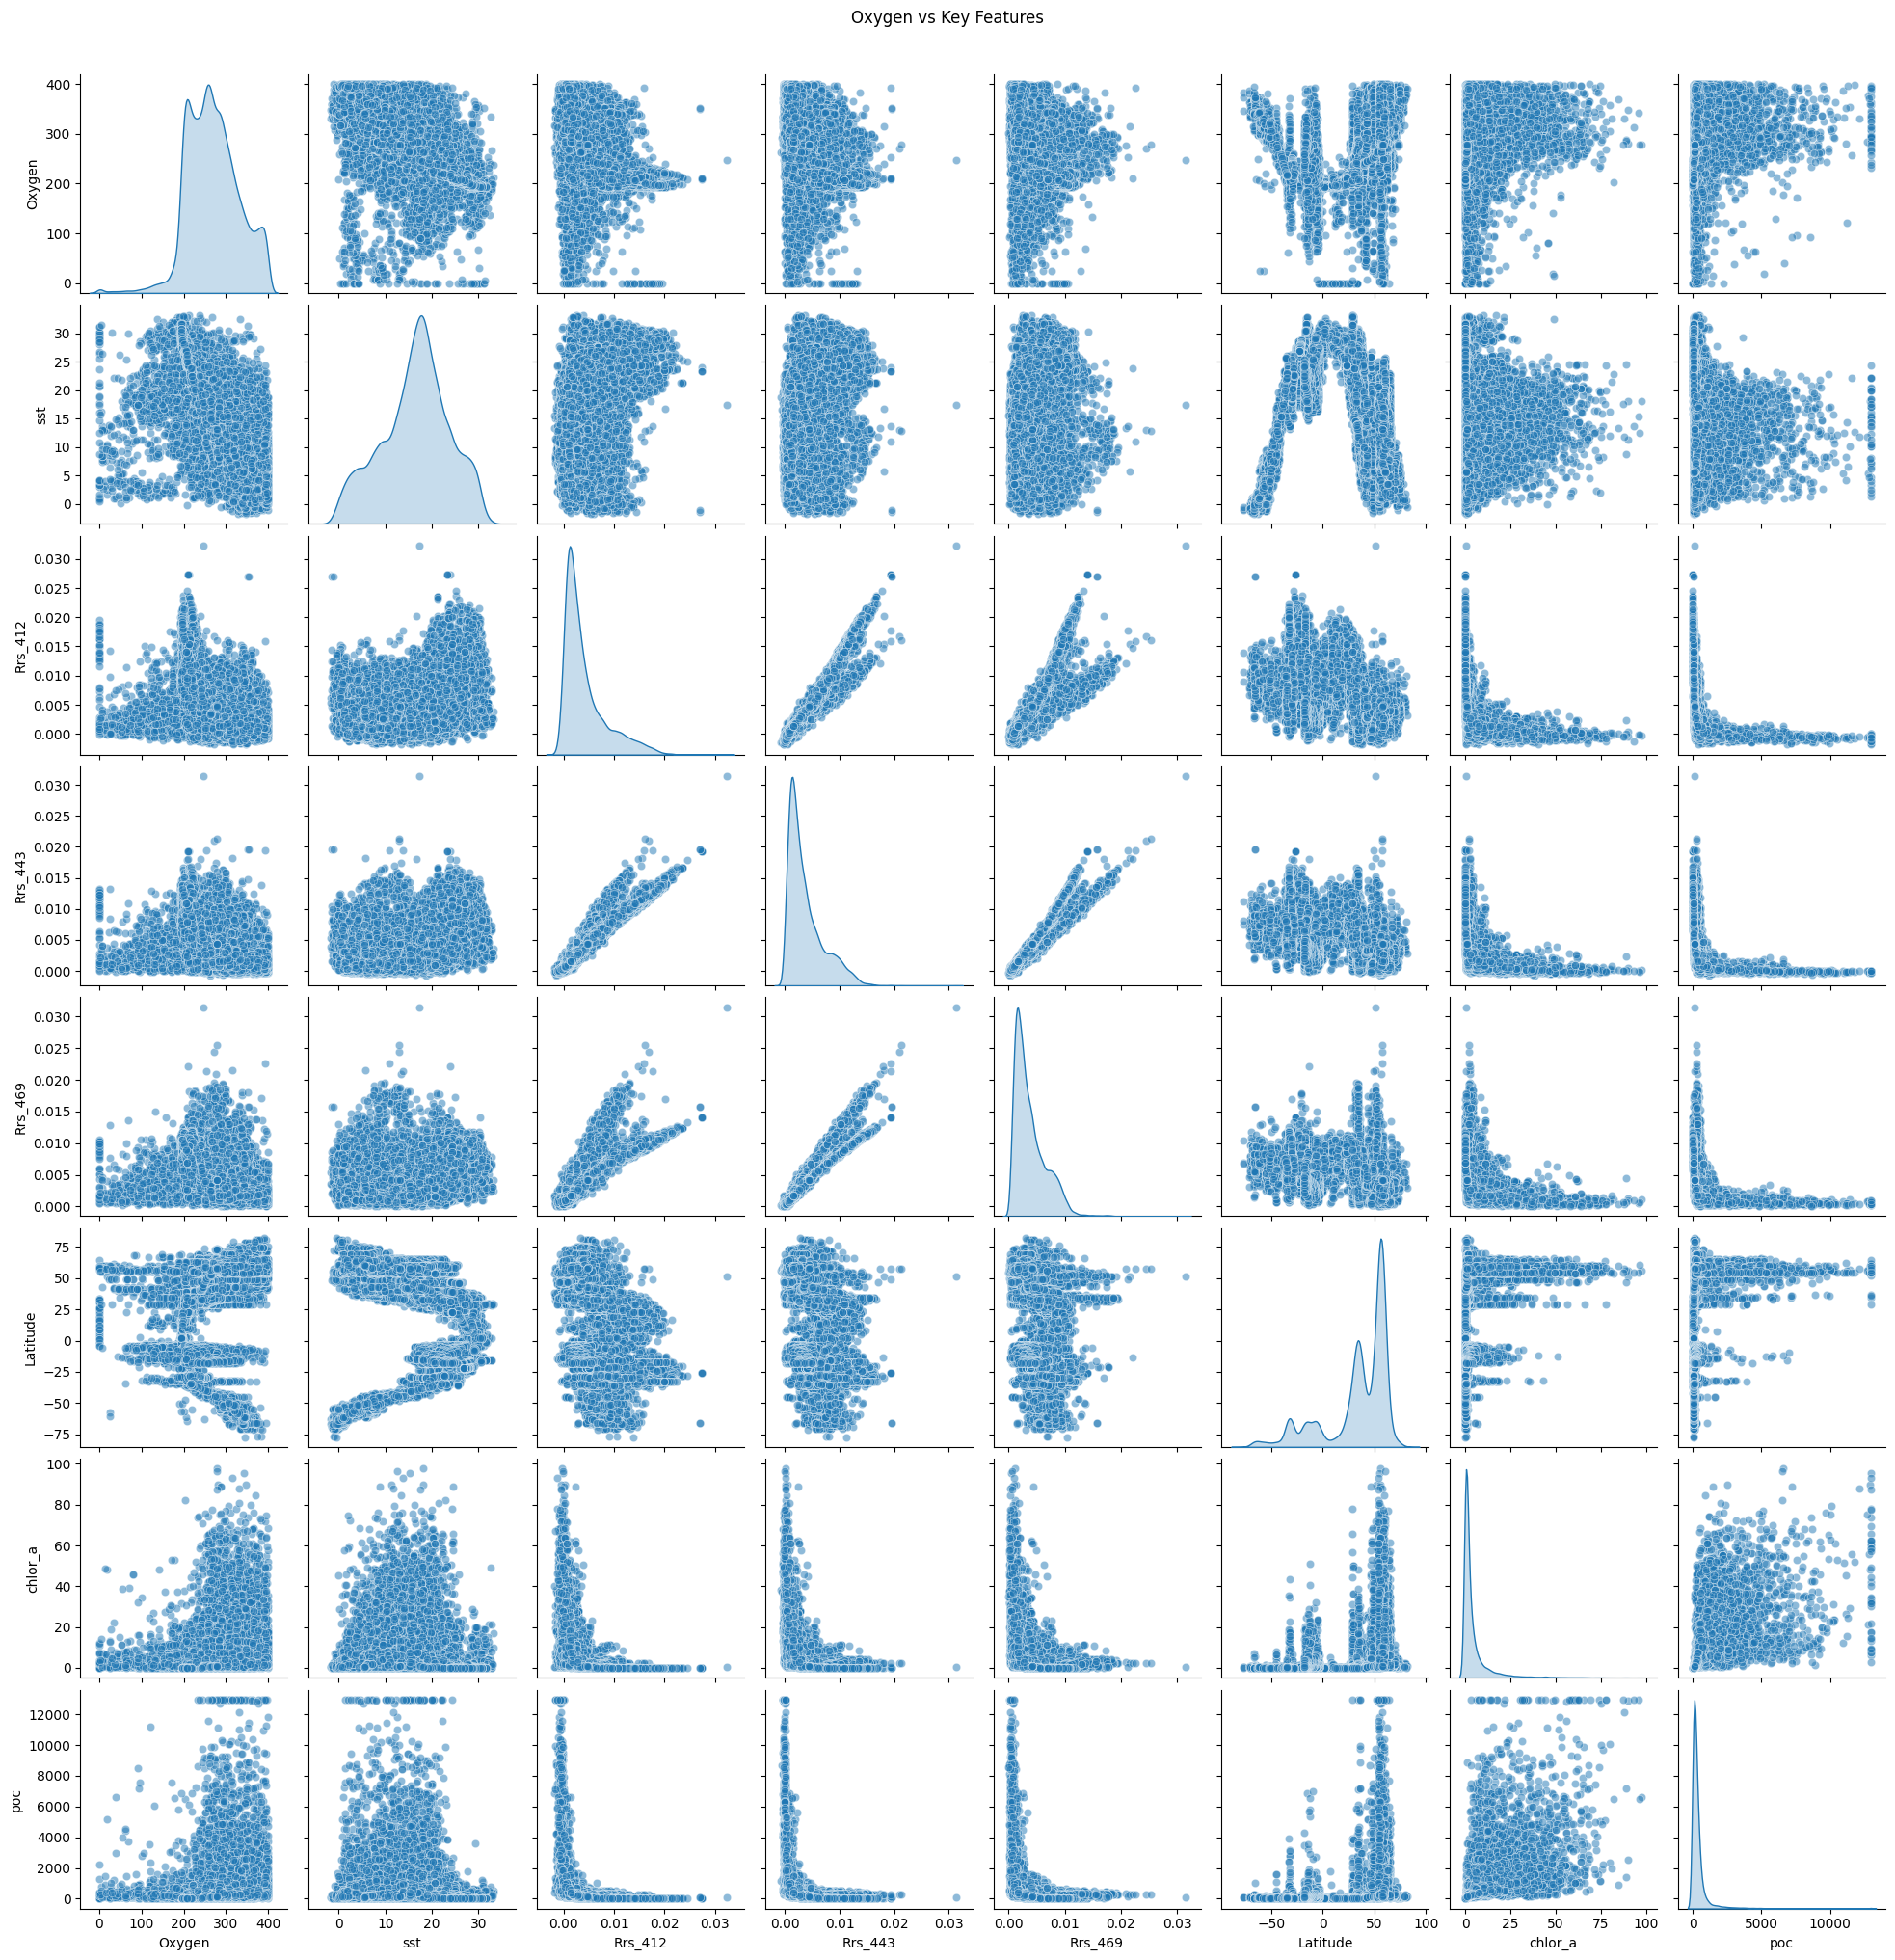

In [ ]:
# Select most important features based on correlation (below)
key_features = ['Oxygen', 'sst', 'Rrs_412', 'Rrs_443', 'Rrs_469', 'Latitude', 'chlor_a', 'poc']

# Create scatter plot matrix
sns.pairplot(training_df[key_features], diag_kind='kde', plot_kws={'alpha':0.5})
plt.suptitle('Oxygen vs Key Features', y=1.02)
plt.show()

### Geographic Coverage Analysis

In [ ]:
# Scatter plot unique coordinates
fig = px.scatter_geo(training_df,
                     lat='Latitude',
                     lon='Longitude',
                     title='Data Coverage Map',
                     projection='natural earth',
                     opacity=0.5)

fig.update_traces(marker=dict(size=3, color='blue'))

fig.update_geos(
    showland=True,
    landcolor='lightgray',
    showocean=True,
    oceancolor='lightblue'
)

fig.show()

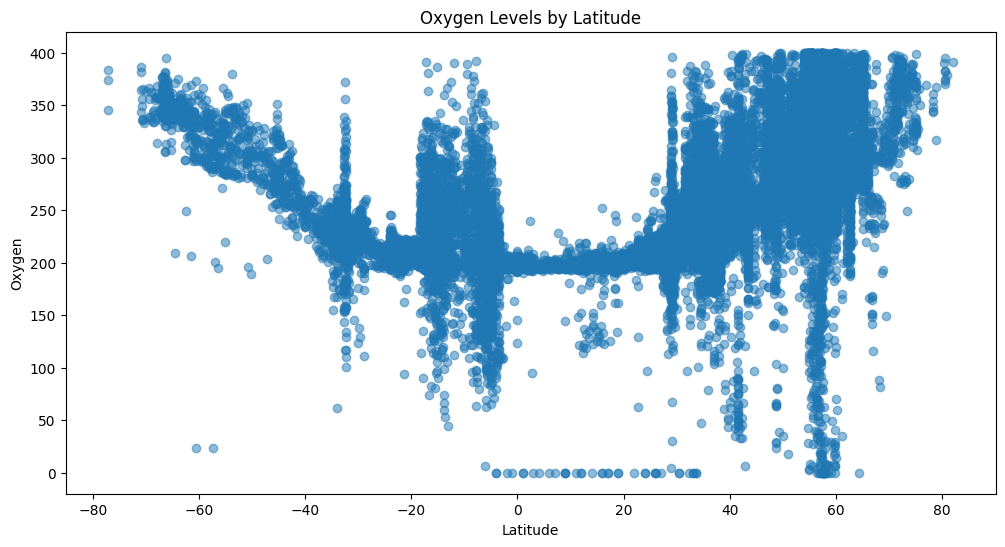

In [ ]:
# Oxygen by Latitude - show geographic patterns
plt.figure(figsize=(12, 6))
plt.scatter(training_df['Latitude'], training_df['Oxygen'], alpha=0.5)
plt.xlabel('Latitude')
plt.ylabel('Oxygen')
plt.title('Oxygen Levels by Latitude')
plt.show()

### Correlation Analysis

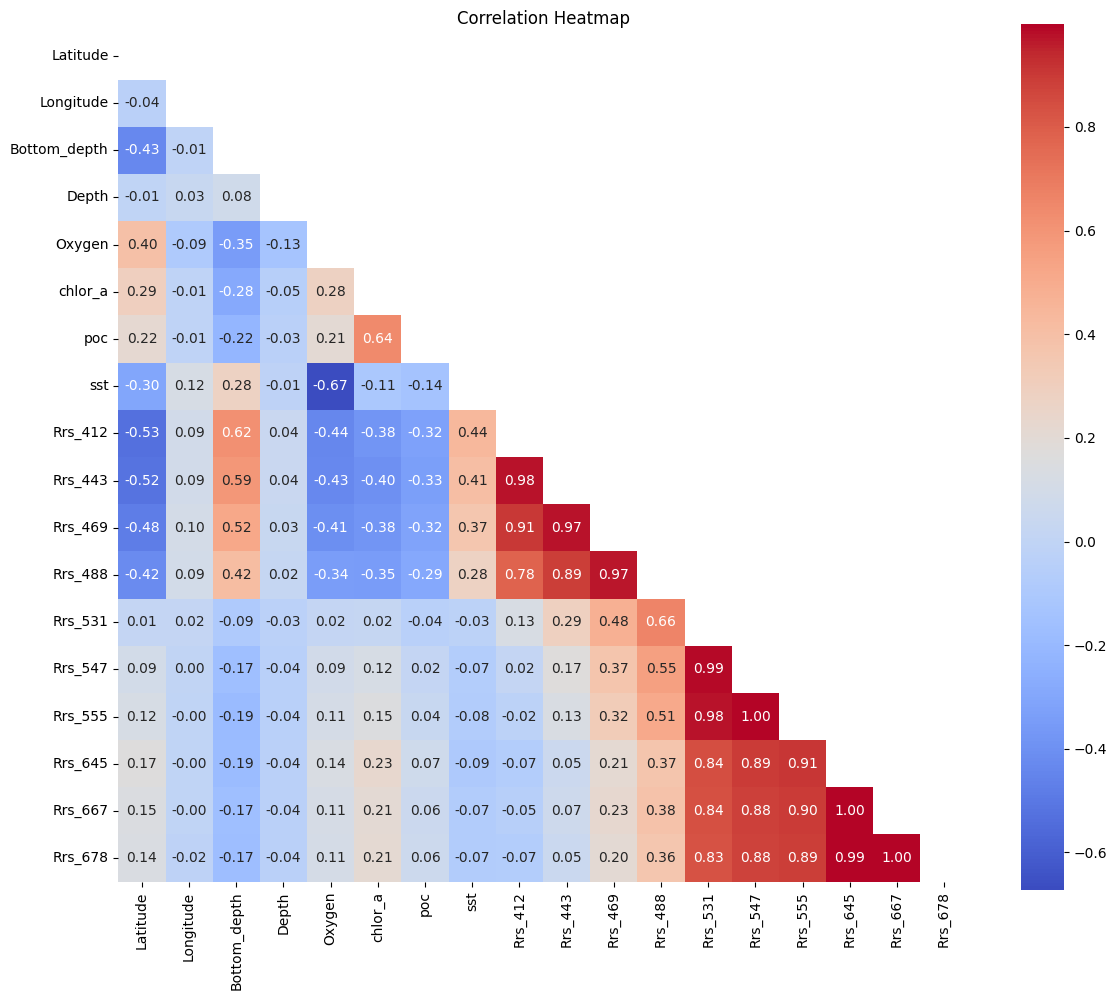

In [ ]:
# Generate a correlation heatmap to visualize relationships between numeric variables
plt.figure(figsize=(12, 10))

# Calculate the correlation matrix for numeric variables
corr = training_df[numeric_cols].corr()

# Create a mask for the upper triangle to avoid redundant display
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate the heatmap with annotations
sns.heatmap(
   corr,
   mask=mask,
   annot=True,
   fmt=".2f",
   cmap="coolwarm",
   square=True
)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
# Get correlations with oxygen, sorted by strength
oxygen_corr = training_df[numeric_cols].corr()['Oxygen'].drop('Oxygen')
oxygen_corr_sorted = oxygen_corr.abs().sort_values(ascending=False)

print("Variables correlation with Oxygen:")
for var in oxygen_corr_sorted.index:
    print(f"{var}: {oxygen_corr[var]:.3f}")

Variables correlation with Oxygen:
sst: -0.672
Rrs_412: -0.439
Rrs_443: -0.433
Rrs_469: -0.407
Latitude: 0.395
Bottom_depth: -0.346
Rrs_488: -0.342
chlor_a: 0.281
poc: 0.205
Rrs_645: 0.136
Depth: -0.133
Rrs_667: 0.111
Rrs_555: 0.107
Rrs_678: 0.106
Longitude: -0.087
Rrs_547: 0.087
Rrs_531: 0.018


## Feature Engineering

In [ ]:
# Exclude non-features
exclude_cols = ['Cast_id', 'Date']

training_df = training_df.drop(columns=exclude_cols)
validation_df = validation_df.drop(columns=exclude_cols)
testing_df = testing_df.drop(columns=exclude_cols)

training_df.head()

Latitude  Longitude  Year  Month  Day  Bottom_depth  Depth  Oxygen  \
0   54.6230    13.0280  2002      7    4          12.0    1.5   278.0   
1   54.5960    18.7737  2002      7    4          49.0    0.0   322.0   
2   54.5777    18.7477  2002      7    4          53.0    0.0   320.0   
3   54.5700    18.6800  2002      7    4          31.0    0.0   328.0   
4   54.5782    18.6610  2002      7    4          33.0    0.0   328.0   

    chlor_a         poc  ...   Rrs_412   Rrs_443   Rrs_469   Rrs_488  \
0  3.398178  274.399994  ...  0.002476  0.001970  0.002248  0.002200   
1  3.311782  242.399994  ...  0.002618  0.002244  0.002216  0.002240   
2  5.786841  294.200012  ...  0.002444  0.001922  0.002112  0.001930   
3  5.830627  295.600006  ...  0.002370  0.001860  0.002052  0.001876   
4  5.830627  295.600006  ...  0.002370  0.001860  0.002052  0.001876   

    Rrs_531   Rrs_547   Rrs_555   Rrs_645   Rrs_667   Rrs_678  
0  0.002864  0.002758  0.002608  0.000644  0.000538  0.000604  
1  0.002920  0.002790  0.002660  0.000500  0.000304  0.000334  
2  0.002808  0.002870  0.002730  0.000560  0.000338  0.000350  
3  0.002746  0.002794  0.002656  0.000522  0.000308  0.000322  
4  0.002746  0.002794  0.002656  0.000522  0.000308  0.000322  

[5 rows x 21 columns]

In [ ]:
# Helper Functions for Feature Engineering

def get_season(row):
    """Hemisphere-aware seasonal classification"""
    month, day, lat = row['Month'], row['Day'], row['Latitude']

    if lat >= 0.0:  # northern hemisphere
        if (month == 12 and day >= 21) or (month in [1, 2]) or (month == 3 and day <= 20):
            return 'Winter'
        elif (month == 3 and day >= 21) or (month in [4, 5]) or (month == 6 and day <= 20):
            return 'Spring'
        elif (month == 6 and day >= 21) or (month in [7, 8]) or (month == 9 and day <= 22):
            return 'Summer'
        else:
            return 'Autumn'
    else:  # southern hemisphere
        if (month == 12 and day >= 21) or (month in [1, 2]) or (month == 3 and day <= 20):
            return 'Summer'
        elif (month == 3 and day >= 21) or (month in [4, 5]) or (month == 6 and day <= 20):
            return 'Autumn'
        elif (month == 6 and day >= 21) or (month in [7, 8]) or (month == 9 and day <= 22):
            return 'Winter'
        else:
            return 'Spring'

def temperature_features(df):
    """
    Temperature-based features.
    Includes SST anomaly and non-linear transformations.
    """
    # SST anomaly (teammate's feature)
    df['sst_anomaly'] = df['sst'] - df.groupby('season')['sst'].transform('mean')

    # Non-linear temperature effects
    df['sst_squared'] = df['sst'] ** 2
    df['sst_cubed'] = df['sst'] ** 3

    return df

def log_transform_skewed_features(df):
    """
    Log transform only HIGHLY skewed features (skewness > 4).
    Keeps both original and log versions for correlation testing.
    """
    # Only the most extremely skewed features - from above analysis
    highly_skewed = [
        'Rrs_667',      # 6.66
        'Rrs_678',      # 6.57
        'Rrs_645',      # 6.27
        'poc',          # 6.20
        'Rrs_531',      # 4.92
        'Rrs_547',      # 4.85
        'Rrs_555',      # 4.76
        'chlor_a',      # 4.25
    ]

    for feature in highly_skewed:
        if feature in df.columns:
            df[f'log_{feature}'] = np.log(df[feature].replace(0, np.nan).clip(lower=1e-10))

    return df


def biomass_ratios(df):
    """
    Biomass efficiency indicators.
    Includes POC/Chlor_a and inverse ratio.
    """
    # POC/Chlor_a ratio
    df['poc_chla_ratio'] = (df['poc'] / df['chlor_a']).replace([np.inf, -np.inf], np.nan)

    # Inverse ratio
    df['chlor_poc_ratio'] = (df['chlor_a'] / df['poc']).replace([np.inf, -np.inf], np.nan)

    return df


def spectral_ratios(df):
    """
    Spectral band ratios for water properties.
    Includes standard ocean color ratios.
    """
    # Blue-green ratio
    df['ratio_443_547'] = (df['Rrs_443'] / df['Rrs_547']).replace([np.inf, -np.inf], np.nan)

    # Standard blue/green ratios (chlorophyll indicators)
    df['ratio_443_555'] = (df['Rrs_443'] / df['Rrs_555']).replace([np.inf, -np.inf], np.nan)

    # Red/Blue ratios (biomass indicators)
    df['ratio_667_443'] = (df['Rrs_667'] / df['Rrs_443']).replace([np.inf, -np.inf], np.nan)

    # Red/Green ratios
    df['ratio_667_555'] = (df['Rrs_667'] / df['Rrs_555']).replace([np.inf, -np.inf], np.nan)

    # Green/Red (turbidity indicator)
    df['ratio_555_667'] = (df['Rrs_555'] / df['Rrs_667']).replace([np.inf, -np.inf], np.nan)

    return df


def normalized_indices(df):
    """Normalized difference indices (robust to atmospheric effects)"""
    # Normalized Difference Chlorophyll Index
    df['ndci'] = ((df['Rrs_667'] - df['Rrs_645']) /
                  (df['Rrs_667'] + df['Rrs_645'])).replace([np.inf, -np.inf], np.nan)

    # Water-adapted NDVI
    df['ndvi_water'] = ((df['Rrs_555'] - df['Rrs_667']) /
                        (df['Rrs_555'] + df['Rrs_667'])).replace([np.inf, -np.inf], np.nan)

    return df


def interaction_terms(df):
    """Feature interactions for non-linear relationships"""
    df['sst_chlor_interaction'] = df['sst'] * df['log_chlor_a']
    df['sst_poc_interaction'] = df['sst'] * df['poc']
    return df


def spatial_features(df):
    """Latitude-based spatial groupings"""
    df['abs_latitude'] = df['Latitude'].abs()
    return df

In [ ]:
# Main Feature Engineering Function and Application

def create_all_candidate_features(df):
    """
    Apply all feature engineering transformations.
    Creates ~25 candidate features for correlation analysis with Oxygen.
    """

    # Temporal features
    df['season'] = df.apply(get_season, axis=1)
    df['day_of_year'] = pd.to_datetime(df[['Year','Month','Day']]).dt.dayofyear

    # Temperature features
    df = temperature_features(df)

    # Log transformations
    df = log_transform_skewed_features(df)

    # Biomass ratios
    df = biomass_ratios(df)

    # Spectral ratios
    df = spectral_ratios(df)

    # Normalized indices
    df = normalized_indices(df)

    # Interaction terms
    df = interaction_terms(df)

    # Spatial features
    df = spatial_features(df)

    return df

# Apply to training data only
training_df = create_all_candidate_features(training_df)

Correlation with Oxygen:

sst_squared             -0.649121
sst_anomaly             -0.647665
abs_latitude             0.635062
sst_cubed               -0.604674
log_chlor_a              0.500690
ratio_443_547           -0.474348
sst_chlor_interaction    0.472223
log_poc                  0.471426
ratio_443_555           -0.470925
poc_chla_ratio          -0.363275
chlor_poc_ratio          0.286326
ratio_667_555            0.240020
log_Rrs_645              0.173969
day_of_year             -0.170485
log_Rrs_555              0.165780
log_Rrs_547              0.116079
sst_poc_interaction      0.107284
ndvi_water              -0.081211
log_Rrs_667              0.064785
log_Rrs_678              0.053177
log_Rrs_531             -0.035391
ndci                    -0.009720
ratio_555_667            0.003355
ratio_667_443            0.001175
dtype: float64


Absolute Correlation with Oxygen:

sst_squared              0.649121
sst_anomaly              0.647665
abs_latitude             0.635062
sst_

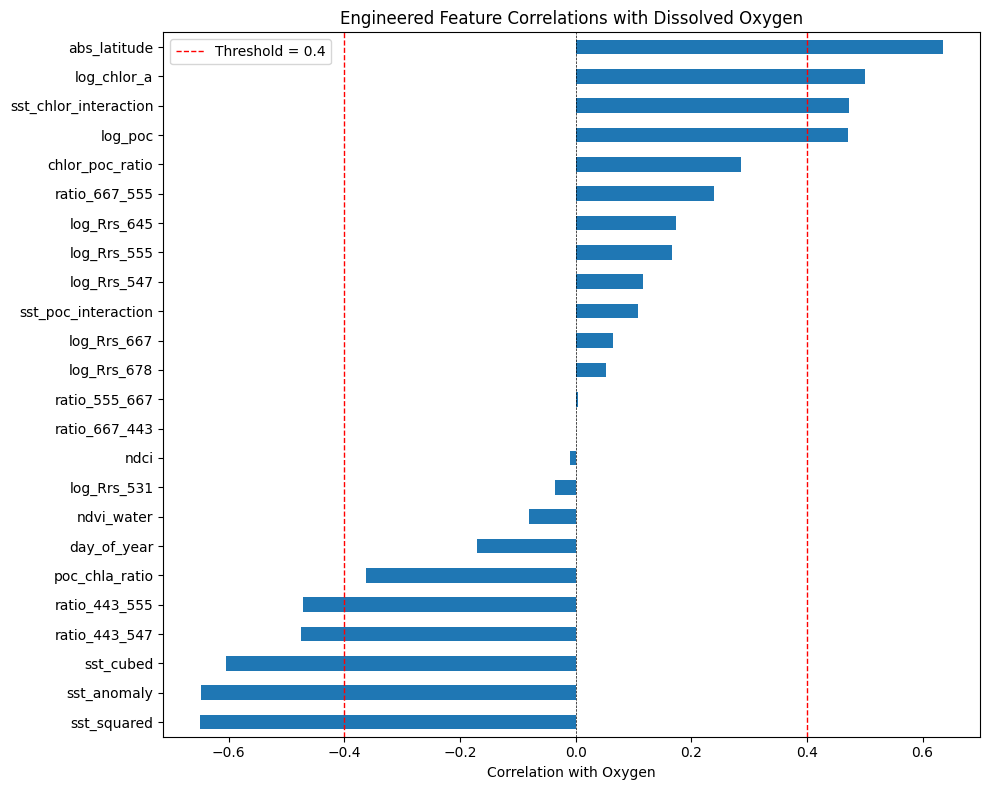

In [ ]:
# Correlation Analysis of Numeric Features

# List of numerica engineered features
engineered_features = [
    'day_of_year',
    'sst_anomaly', 'sst_squared', 'sst_cubed',
    'log_chlor_a', 'log_poc',
    'log_Rrs_531', 'log_Rrs_547', 'log_Rrs_555',
    'log_Rrs_645', 'log_Rrs_667', 'log_Rrs_678',
    'poc_chla_ratio', 'chlor_poc_ratio',
    'ratio_443_547', 'ratio_443_555', 'ratio_667_443', 'ratio_667_555', 'ratio_555_667',
    'ndci', 'ndvi_water',
    'sst_chlor_interaction', 'sst_poc_interaction',
    'abs_latitude'
]

# Calculate correlations with Oxygen
correlations = training_df[engineered_features].corrwith(training_df['Oxygen'])
correlations_abs = correlations.abs()

# Sort by absolute correlation
print("Correlation with Oxygen:\n")
print(correlations.sort_values(key=abs, ascending=False))
print("\n" + "="*50 + "\n")
print("Absolute Correlation with Oxygen:\n")
print(correlations_abs.sort_values(ascending=False))

# Visualize correlations

plt.figure(figsize=(10, 8))
correlations_sorted = correlations.sort_values()
correlations_sorted.plot(kind='barh')
plt.xlabel('Correlation with Oxygen')
plt.title('Engineered Feature Correlations with Dissolved Oxygen')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=0.4, color='red', linestyle='--', linewidth=1, label='Threshold = 0.4')
plt.axvline(x=-0.4, color='red', linestyle='--', linewidth=1)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Feature Selection

# Select features with |correlation| > 0.4
THRESHOLD = 0.4
final_features = correlations_abs[correlations_abs > THRESHOLD].index.tolist()

print(f"\n{'='*50}")
print(f"Features with |corr| > {THRESHOLD}: {len(final_features)}")
print(f"{'='*50}")
print(final_features)


Features with |corr| > 0.4: 9
['sst_anomaly', 'sst_squared', 'sst_cubed', 'log_chlor_a', 'log_poc', 'ratio_443_547', 'ratio_443_555', 'sst_chlor_interaction', 'abs_latitude']


In [ ]:
# Create Final Features on Validation and Test Sets

def create_final_features_only(df):
    """
    Create only the selected engineered features.
    This function creates the features from final_features + season.
    """

    # Categorical features
    df['season'] = df.apply(get_season, axis=1)

    # Temperature features
    df['sst_squared'] = df['sst'] ** 2
    df['sst_cubed'] = df['sst'] ** 3
    df['sst_anomaly'] = df['sst'] - df.groupby('season')['sst'].transform('mean')

    # Spatial features
    df['abs_latitude'] = df['Latitude'].abs()

    # Biomass features
    df['log_chlor_a'] = np.log(df['chlor_a'].replace(0, np.nan).clip(lower=1e-10))
    df['log_poc'] = np.log(df['poc'].replace(0, np.nan).clip(lower=1e-10))

    # Spectral ratio features
    df['ratio_443_547'] = (df['Rrs_443'] / df['Rrs_547']).replace([np.inf, -np.inf], np.nan)
    df['ratio_443_555'] = (df['Rrs_443'] / df['Rrs_555']).replace([np.inf, -np.inf], np.nan)

    # Interaction features
    df['sst_chlor_interaction'] = df['sst'] * df['log_chlor_a']

    return df

# Apply to validation and test sets
validation_df = create_final_features_only(validation_df)
testing_df = create_final_features_only(testing_df)


In [ ]:
# Multicollinearity Check and Redundant Feature Removal

# Selected numerical features
selected_numerical = [f for f in final_features if f in training_df.columns]

# Calculate correlation matrix
selected_corr_matrix = training_df[selected_numerical].corr()

# Identify features to drop (|r| > 0.95 with another feature)
features_to_drop = set()
REDUNDANCY_THRESHOLD = 0.95

for i in range(len(selected_numerical)):
    for j in range(i+1, len(selected_numerical)):
        if abs(selected_corr_matrix.iloc[i, j]) > REDUNDANCY_THRESHOLD:
            feat_i = selected_numerical[i]
            feat_j = selected_numerical[j]

            # Keep the one with higher correlation to Oxygen
            if abs(correlations[feat_i]) >= abs(correlations[feat_j]):
                features_to_drop.add(feat_j)
            else:
                features_to_drop.add(feat_i)

print(f"Features to drop due to redundancy (|r| > {REDUNDANCY_THRESHOLD}):")
print(features_to_drop)

# Remove redundant features from must_keep
final_features_refined = [f for f in final_features if f not in features_to_drop]

print(f"\nFinal features after redundancy removal: {len(final_features_refined)}")
print(final_features_refined)


Features to drop due to redundancy (|r| > 0.95):
{'ratio_443_555', 'sst_cubed'}

Final features after redundancy removal: 7
['sst_anomaly', 'sst_squared', 'log_chlor_a', 'log_poc', 'ratio_443_547', 'sst_chlor_interaction', 'abs_latitude']


In [ ]:
# Filter to Final Columns

# Include Season in final features
final_features = final_features + ['season']

print(f"\nFinal engineered features: {len(final_features)}")
print(final_features)

# Original features to keep for reference
original_features = [
    'Latitude', 'Longitude', 'Year', 'Month', 'Day',
    'chlor_a', 'poc', 'sst',
    'Rrs_412', 'Rrs_443', 'Rrs_469', 'Rrs_488',
    'Rrs_531', 'Rrs_547', 'Rrs_555',
    'Rrs_645', 'Rrs_667', 'Rrs_678'
]

# Combine: engineered + original + target
final_columns = original_features + final_features + ['Oxygen']

# Remove duplicates (in case any overlap)
final_columns = list(dict.fromkeys(final_columns))

# Keep only these columns in each dataset
training_df = training_df[final_columns]
validation_df = validation_df[final_columns]
testing_df = testing_df[final_columns]


print("Dataset shapes:")
print(f"  training_df: {training_df.shape}")
print(f"  validation_df: {validation_df.shape}")
print(f"  testing_df: {testing_df.shape}")
print(f"\nTotal columns: {len(final_columns)}")


Final engineered features: 10
['sst_anomaly', 'sst_squared', 'sst_cubed', 'log_chlor_a', 'log_poc', 'ratio_443_547', 'ratio_443_555', 'sst_chlor_interaction', 'abs_latitude', 'season']
Dataset shapes:
  training_df: (31728, 29)
  validation_df: (6777, 29)
  testing_df: (6932, 29)

Total columns: 29


In [ ]:
training_df.head()

Latitude  Longitude  Year  Month  Day   chlor_a         poc        sst  \
0   54.6230    13.0280  2002      7    4  3.398178  274.399994  15.715000   
1   54.5960    18.7737  2002      7    4  3.311782  242.399994  16.369999   
2   54.5777    18.7477  2002      7    4  5.786841  294.200012  16.100000   
3   54.5700    18.6800  2002      7    4  5.830627  295.600006  16.010000   
4   54.5782    18.6610  2002      7    4  5.830627  295.600006  16.010000   

    Rrs_412   Rrs_443  ...  sst_squared    sst_cubed  log_chlor_a   log_poc  \
0  0.002476  0.001970  ...   246.961230  3880.995764     1.223239  5.614587   
1  0.002618  0.002244  ...   267.976865  4386.780994     1.197486  5.490589   
2  0.002444  0.001922  ...   259.210012  4173.281297     1.755587  5.684260   
3  0.002370  0.001860  ...   256.320107  4103.684977     1.763125  5.689007   
4  0.002370  0.001860  ...   256.320107  4103.684977     1.763125  5.689007   

   ratio_443_547  ratio_443_555  sst_chlor_interaction  abs_latitude  season  \
0       0.714286       0.755368              19.223206       54.6230  Summer   
1       0.804301       0.843609              19.602851       54.5960  Summer   
2       0.669687       0.704029              28.264945       54.5777  Summer   
3       0.665712       0.700301              28.227624       54.5700  Summer   
4       0.665712       0.700301              28.227624       54.5782  Summer   

   Oxygen  
0   278.0  
1   322.0  
2   320.0  
3   328.0  
4   328.0  

[5 rows x 29 columns]

In [ ]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31728 entries, 0 to 34407
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Latitude               31728 non-null  float64
 1   Longitude              31728 non-null  float64
 2   Year                   31728 non-null  int64  
 3   Month                  31728 non-null  int64  
 4   Day                    31728 non-null  int64  
 5   chlor_a                31728 non-null  float64
 6   poc                    31728 non-null  float64
 7   sst                    31728 non-null  float64
 8   Rrs_412                31728 non-null  float64
 9   Rrs_443                31728 non-null  float64
 10  Rrs_469                31728 non-null  float64
 11  Rrs_488                31728 non-null  float64
 12  Rrs_531                31728 non-null  float64
 13  Rrs_547                31728 non-null  float64
 14  Rrs_555                31728 non-null  float64
 15  Rrs_645

In [ ]:
# Export Processed Data Split Sets
training_df.to_csv('/content/drive/MyDrive/Colab Notebooks/MADS/SIADS 699/Data/Data Splits/Processed/Training Set.csv', index=False)
validation_df.to_csv('/content/drive/MyDrive/Colab Notebooks/MADS/SIADS 699/Data/Data Splits/Processed/Validation Set.csv', index=False)
testing_df.to_csv('/content/drive/MyDrive/Colab Notebooks/MADS/SIADS 699/Data/Data Splits/Processed/Testing Set.csv', index=False)

In [ ]:
# Check if same locations appear in train and test
train_locations = set(zip(training_df['Latitude'].round(1), training_df['Longitude'].round(1)))
test_locations = set(zip(testing_df['Latitude'].round(1), testing_df['Longitude'].round(1)))

overlap = train_locations.intersection(test_locations)
print(f"Locations in both train and test: {len(overlap)}")
print(f"Train-only locations: {len(train_locations - overlap)}")
print(f"Test-only locations: {len(test_locations - overlap)}")
print(f"Overlap percentage: {len(overlap)/len(test_locations)*100:.1f}%")

Locations in both train and test: 1481
Train-only locations: 9194
Test-only locations: 1663
Overlap percentage: 47.1%
